In [1]:
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
# from tqdm import tqdm
import contfrac
from fractions import Fraction

from qiskit.algorithms import Shor
from qiskit import QuantumCircuit, Aer, execute, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.algorithms.factorizers.shor import Shor
from qiskit.visualization import plot_histogram

from qiskit import IBMQ

#from qarithmetic import add, cadd, qft, iqft, cmult

In [2]:
#IBMQ.save_account("7960f43c93c344088d7620a4543c6f283e44f5cfa03518cab0e58de04b3562533b10d37b37852829902265ba13c5ba3d3dc6b7338b0917da358afbf585af2463")
#IBMQ.load_account()
IBMQ.enable_account("7960f43c93c344088d7620a4543c6f283e44f5cfa03518cab0e58de04b3562533b10d37b37852829902265ba13c5ba3d3dc6b7338b0917da358afbf585af2463")         

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
print(IBMQ.providers())
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
provider.backends(filters=lambda x: x.configuration().n_qubits >= 22
                                    and x.configuration().simulator
                                    and x.status().operational==True)
provider.get_backend('ibmq_qasm_simulator')

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]


<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
##QARITHMETIC
from math import pi
from qiskit import QuantumRegister, QuantumCircuit, AncillaRegister
from qiskit.circuit.library import SXdgGate

# Draper adder that takes |a>|b> to |a>|a+b>.
# |a> has length x and is less than or equal to n
# |b> has length n+1 (left padded with a zero).
# https://arxiv.org/pdf/quant-ph/0008033.pdf
def add(circ, a, b, n):
    # move n forward by one to account for overflow
    n += 1

    # Take the QFT.
    qft(circ, b, n)

    # Compute controlled-phases.
    # Iterate through the targets.
    for i in range(n,0,-1):
        # Iterate through the controls.
        for j in range(i,0,-1):
            # If the qubit a[j-1] exists run cu1, if not assume the qubit is 0 and never existed
            if len(a) - 1 >= j - 1:
                circ.cp(2*pi/2**(i-j+1), a[j-1], b[i-1])

    # Take the inverse QFT.
    iqft(circ, b, n)



# Quantum Fourier transform of |q>, of length n.
# See Fig. 3 of Khosropour et al. (2011) for a circuit diagram.
def qft(circ, q, n):
    # Iterate through the target.
    for i in range(n,0,-1):
        # Apply the Hadamard gate to the target.
        circ.h(q[i-1])

        # Iterate through the control.
        for j in range(i-1,0,-1):
            circ.cp(2*pi/2**(i-j+1), q[j-1], q[i-1])

# Inverse Fourier transform of |q>, of length n.
def iqft(circ, q, n):
    # Iterate through the target.
    for i in range(1,n+1):
        # Iterate through the control.
        for j in range(1,i):
            # The inverse Fourier transform just uses a negative phase.
            circ.cp(-2*pi/2**(i-j+1), q[j-1], q[i-1])

        # Apply the Hadamard gate to the target.
        circ.h(q[i-1])




In [38]:
# functions

#a,b -> a,b+a or a,b-a
def makeAdder(nbits,adding = True,control = False):
    qc = QuantumCircuit(2*nbits+1) #a is size N, b is N + 1
    add(qc, range(nbits), range(nbits,2*nbits+1),nbits)
    addergate = qc.to_gate()
    addergate.name = control*"c"+"adder"
    iaddergate = addergate.inverse()
    iaddergate.name = control*"c"+"inverse adder"
    if adding:
        return addergate
    else:
        return iaddergate

def binary(num,length):
    b = bin(num)[2:]
    return "0"*(length-len(b))+str(b)

def x(number,length,controls = 0): #x is obviously a terrible name, it changes a decimal number to a series of x gates
    circ = QuantumCircuit(length)
    for i,num in enumerate(binary(number,length)):
        if num == "1":
            circ.x(length - 1 - i)
        xgate = circ.to_gate()
        xgate.name = str(number)
    if controls != 0:
        cxgate = xgate.control(controls)
        return cxgate #num bitts will be controls + length
    else:
        return xgate

def makeAdderMod(a,b,t1,t2,n,nbits,N,control = False): #a,b,n quantum registers, output a,a+bmodN, N. t and aux both start and end zero
    qc = QuantumCircuit(a, b, t1, t2, n)
    qc.append(makeAdder(nbits,True),range(2*nbits+1))
    qc.swap(a,n)
    qc.append(makeAdder(nbits, False),range(2*nbits+1))
    qc.x(t1)
    qc.cx(t1,t2)
    qc.x(t1)
    #set top register to zero by bitwise adding N
    qc.append(x(N,nbits,1),t2[:] + a[:])
    qc.append(makeAdder(nbits,True),range(2*nbits+1)) #adds nothing if b is already positive
    #turn it back into N
    qc.append(x(N,nbits,1),t2[:] + a[:])
    qc.swap(a,n)
    qc.append(makeAdder(nbits, False),range(2*nbits+1))
    qc.cx(t1,t2) #t2 reset to zero
    qc.append(makeAdder(nbits, True),range(2*nbits+1))
    addmod = qc.to_gate()
    addmod.name = "a + b mod "+str(N)
    
    if control:
        caddmod = addmod.control(1)
        return caddmod
    else:
        return addmod
    
def makecmult(c, xreg, tempa, y, t1, t2, n, numa, nbits, N,inv = False):
    qc = QuantumCircuit(c,xreg,tempa,y,t1,t2,n)
    for p in range(nbits):
        qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
        qc.append(makeAdderMod(tempa,y,t1,t2,n,nbits,N),tempa[:] + y[:] + t1[:] + t2[:] + n[:])
        qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
    qc.x(c)
    for q in range(nbits):
        qc.ccx(c,xreg[q],y[q])
    qc.x(c)
    cmult = qc.to_gate()
    iqc = qc.inverse()
    icmult = iqc.to_gate()
    cmult.name = "times "+str(numa)+" mod "+str(N)
    icmult.name = "inverse of (times "+str(numa)+" mod "+str(N)+")"
    return icmult if inv else cmult

def fakecmult(c, xreg, tempa, y, t1, t2, n, numa, nbits, N,inv = False):
    qc = QuantumCircuit(c,xreg,tempa,y,t1,t2,n)
    cmult = qc.to_gate()
    iqc = qc.inverse()
    icmult = iqc.to_gate()
    cmult.name = "times "+str(numa)+" mod "+str(N)
    icmult.name = "divided by "+str(modinv(numa,N))+" mod "+str(N)
    return icmult if inv else cmult

def makea2pmod(out1, tempa, out2, t1, t2, n, numa,p,nbits,N):
    c = QuantumRegister(1)
    qc = QuantumCircuit(c, out1, tempa, out2, t1, t2, n)
    #print(l,(numa**(2**l))%N) #it's the iversion that's wrong
    qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**p))%N, nbits, N),list(range(0,4*nbits+3)))
    qc.swap(out1,out2)
    qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**p))%N,N), nbits, N, True),list(range(0,4*nbits+3)))
    #qc = qc.to_gate()
    qc.name = str(numa)+"^"+str(2**p)+" mod "+str(N)
    return qc



def makeAXmod(xreg, out1, tempa, out2, t1, t2, n,numa,mbits,nbits,N,control = False):
    qc = QuantumCircuit(xreg, out1, tempa, out2, t1, t2, n)
    #x starts and finishes as NOT ZERO
    c = QuantumRegister(1)
    for l in range(mbits):
        #print(l,(numa**(2**l))%N) #it's the iversion that's wrong
        qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**l))%N, nbits, N),[l] + list(range(mbits,mbits+(4*nbits+2))))
        qc.swap(out1,out2)
        qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**l))%N,N), nbits, N, True),[l] + list(range(mbits,mbits+(4*nbits+2))))
    #qc.append(x(numx,mbits),xreg[:]) #reset x to zero
    if control:
        qc = qc.control(1)
    AXmod = qc.to_gate()
    AXmod.name = str(numa)+"^x mod "+str(N)        
    return AXmod

#not my code (https://stackoverflow.com/questions/4798654/modular-multiplicative-inverse-function-in-python)
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)
def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m
    
def QFTd(n): #source qiskit
    circuit = QuantumCircuit(n)
    for bit in range(n//2):
        circuit.swap(bit,n-bit-1)
    for j in range(n):
        for m in range(j):
            circuit.cp(-np.pi/(2**(j-m)), m, j) 
            #rotate by -pi/2^(j-m) on the bit j (target), which is controlled by each less significant bit m
        circuit.h(j)
    circuit.name = "QFT"
    return circuit

def makeSum(inverse = False):
    qc = QuantumCircuit(3)
    qc.cx(1,2)
    qc.cx(0,2)
    return qc.inverse() if inverse else qc

def carry(inverse = False):
    qc = QuantumCircuit(4)
    qc.ccx(1,2,3)
    qc.cx(1,2)
    qc.ccx(0,2,3)
    return qc.inverse() if inverse else qc
    
def sim(qc): #prints simulated results of 2 classical registers
    backend_sim = Aer.get_backend('aer_simulator')
    job_sim = execute(qc, backend_sim,shots = 100)
    result_sim = job_sim.result()
    results = str(list(result_sim.get_counts().keys())[0]).split(" ") #result of add is b+a a
    resultsint = [int(res,2) for res in results]
    print(resultsint[1],resultsint[0])


ca,cb = ClassicalRegister(4),ClassicalRegister(5)
q = QuantumRegister(9)
qc = QuantumCircuit(q,ca,cb)
qc.append(x(12,4),range(4))
qc.append(x(12,4),range(4,8))
qc.append(makeAdder(4,True),range(9))
qc.barrier()
qc.measure(range(4),ca)
qc.measure(range(4,9),cb)
sim(qc)
#qc = qc.decompose()
qc.draw(output="text",plot_barriers=False,fold = -1)

12 24


┌─────┐┌────────┐ ┌─┐                        
q216_0: ┤0    ├┤0       ├─┤M├────────────────────────
        │     ││        │ └╥┘┌─┐                     
q216_1: ┤1    ├┤1       ├──╫─┤M├─────────────────────
        │  12 ││        │  ║ └╥┘┌─┐                  
q216_2: ┤2    ├┤2       ├──╫──╫─┤M├──────────────────
        │     ││        │  ║  ║ └╥┘┌─┐               
q216_3: ┤3    ├┤3       ├──╫──╫──╫─┤M├───────────────
        ├─────┤│        │  ║  ║  ║ └╥┘┌─┐            
q216_4: ┤0    ├┤4 adder ├──╫──╫──╫──╫─┤M├────────────
        │     ││        │  ║  ║  ║  ║ └╥┘┌─┐         
q216_5: ┤1    ├┤5       ├──╫──╫──╫──╫──╫─┤M├─────────
        │  12 ││        │  ║  ║  ║  ║  ║ └╥┘┌─┐      
q216_6: ┤2    ├┤6       ├──╫──╫──╫──╫──╫──╫─┤M├──────
        │     ││        │  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
q216_7: ┤3    ├┤7       ├──╫──╫──╫──╫──╫──╫──╫─┤M├───
        └─────┘│        │  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q216_8: ───────┤8       ├──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
               └────────┘  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
 c25: 4/═══════════════════╩══╩══╩══╩══╬══╬══╬══╬══╬═
                           0  1  2  3  ║  ║  ║  ║  ║ 
                                       ║  ║  ║  ║  ║ 
 c26: 5/═══════════════════════════════╩══╩══╩══╩══╩═
                                       0  1  2  3  4

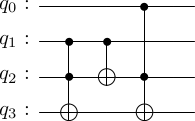

In [8]:
qc = QuantumCircuit(4)
qc.append(carry(),range(4))
qc.decompose().draw(output = "latex")

2 0


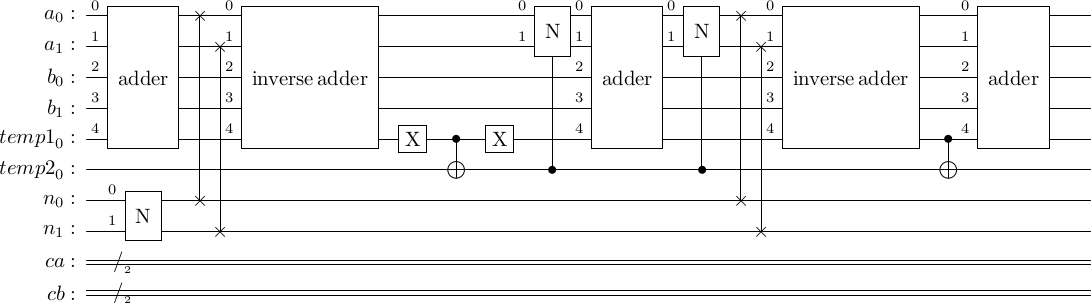

In [12]:
#modular addition
N = 33
numa = 15
numb = 12  #works as long as a+b < 2N (always true for our purposes probably)
nbits = 6

a = QuantumRegister(nbits,"a")
b = QuantumRegister(nbits,"b")
t1 = QuantumRegister(1,"temp1")
n = QuantumRegister(nbits,"n")
t2 = QuantumRegister(1,"temp2")
ca = ClassicalRegister(nbits,"ca")
cb = ClassicalRegister(nbits,"cb")

qc = QuantumCircuit(a, b, t1, t2, n, ca, cb)

#initialise qubits
qc.append(x(numa,nbits),a[:])
qc.append(x(numb,nbits),b)
qc.append(x(N,nbits),n)

#draw the circuit    
qc.append(makeAdder(nbits,True),range(2*nbits+1))
qc.swap(a,n)
qc.append(makeAdder(nbits, False),range(2*nbits+1))
qc.x(t1)
qc.cx(t1,t2)
qc.x(t1)
#set top register to zero by bitwise adding N
qc.append(x(N,nbits,1),t2[:] + a[:])
qc.append(makeAdder(nbits,True),range(2*nbits+1))

#turn it back into N
#print()
qc.append(x(N,nbits,1),t2[:] + a[:])
# for i,num in enumerate(binary(N,nbits)):
#     if num == "1":
#         qc.cx(t2,a[nbits - 1 - i])
#qc.barrier()
qc.swap(a,n)
qc.append(makeAdder(nbits, False),range(2*nbits+1))
qc.cx(t1,t2) #t2 reset to zero
qc.append(makeAdder(nbits, True),range(2*nbits+1))


# qc.measure(a,ca)
# qc.measure(b,cb)
#sim(qc)
print(numa,(numa+numb)%N) #check against correct value
qc.draw(output = "latex",fold = -1,plot_barriers = False)
#result is a, a+b mod N

2 2


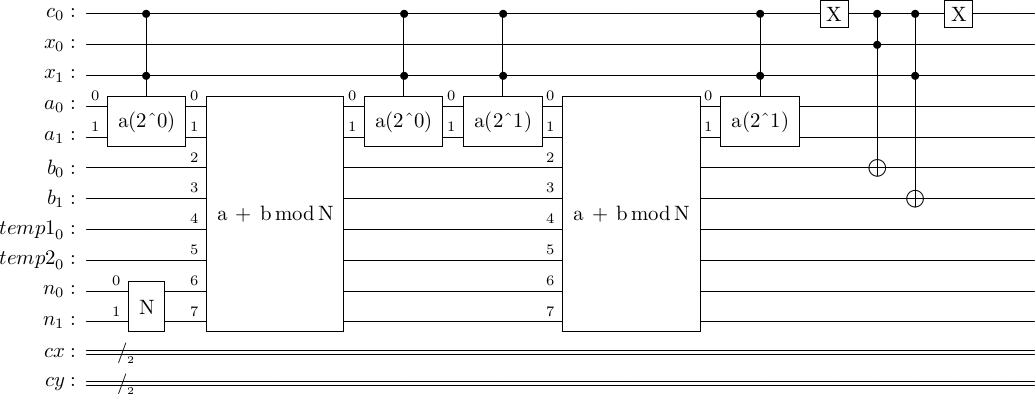

In [21]:
#controlled mult
N = 33
numx = 6
numa = 5
nbits = 6 #goal = c,x,0 -> c,x,ax mod N
on = True

c = QuantumRegister(1,"c")         #control for next step
xreg = QuantumRegister(nbits,"x")  #output 1
tempa = QuantumRegister(nbits,"a")#temp from adder (nbits)
y = QuantumRegister(nbits,"b")     #output 2
t1 = QuantumRegister(1,"temp1")    #temp from adder (1)
t2 = QuantumRegister(1,"temp2")    #temp from adder (1)
n = QuantumRegister(nbits,"n")     #N               (nbits)
cx = ClassicalRegister(nbits,"cx") #answer
cy = ClassicalRegister(nbits,"cy") #answer

qc = QuantumCircuit(c, xreg, tempa, y, t1, t2, n, cx, cy)
#initialise qubits
qc.append(x(numx,nbits),xreg)
qc.append(x(N,nbits),n)
if on:
    qc.append(x(1,1),c)
    
for p in range(nbits):
    qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
    qc.append(makeAdderMod(tempa,y,t1,t2,n,nbits,N),tempa[:] + y[:] + t1[:] + t2[:] + n[:])
    qc.append(x((2**p*numa)%N,nbits,2),c[:] + xreg[p:p+1] + tempa[:])
qc.x(c)
for q in range(nbits):
    qc.ccx(c,xreg[q],y[q])
qc.x(c)


qc.barrier()
# qc.measure(xreg,cx)
# qc.measure(y,cy)
# #sim(qc)
print(numx,(numa*numx)%N)
qc.draw(output= "latex",fold = -1,plot_barriers=False)

#gate, controlled gate

1 0


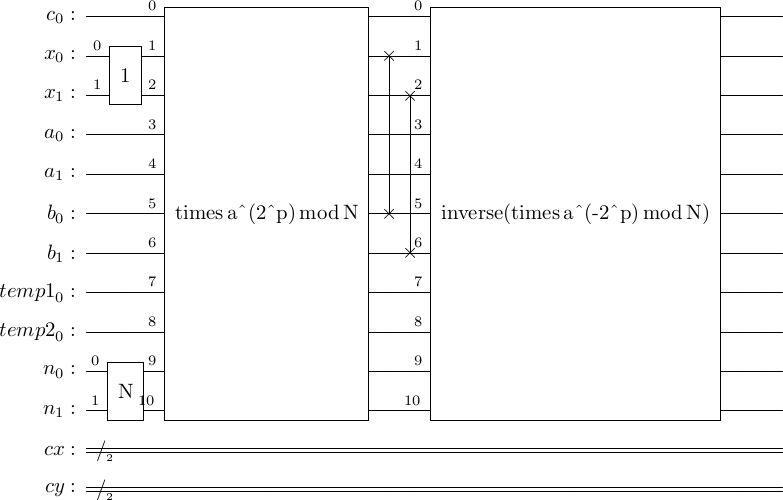

In [39]:
N = 33
numx = 6
numa = 5
nbits = 6
p = 1 #power of 2
#result = a^x mod n


#xreg = QuantumRegister(mbits,"x")     #control, max x is 2^nbits for now but we can define mbits instead
c = QuantumRegister(1,"c")
out1 = QuantumRegister(nbits,"x")  #output 1
tempa = QuantumRegister(nbits,"a")#temp from adder (nbits)
out2 = QuantumRegister(nbits,"b")  #temp from cmult
t1 = QuantumRegister(1,"temp1")       #temp from adder (1)
t2 = QuantumRegister(1,"temp2")       #temp from adder (1)
n = QuantumRegister(nbits,"n")        #N               (nbits)
cx = ClassicalRegister(nbits,"cx")    #answer (same size as xreg)
cy = ClassicalRegister(nbits,"cy")    #answer 

qc = QuantumCircuit(c, out1, tempa, out2, t1, t2, n, cx, cy)
#initialise qubits
# qc.append(x(numx,mbits),xreg)
qc.x(c)
qc.append(x(1,nbits),out1)
qc.append(x(N,nbits),n)
#print(l,(numa**(2**l))%N) #it's the iversion that's wrong
qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, (numa**(2**p))%N, nbits, N),list(range(0,4*nbits+3)))
qc.swap(out1,out2)
qc.append(makecmult(c, out1, tempa, out2, t1, t2, n, modinv((numa**(2**p))%N,N), nbits, N, True),list(range(0,4*nbits+3)))              

    
qc.barrier()
# qc.measure(out2,cx)
# qc.measure(out1,cy)

#sim(qc)
style = {'backgroundcolor':'blue'}
print(numx,(numa**numx)%N)
qc.draw(output= "latex",fold = -1,style = style,plot_barriers=False)

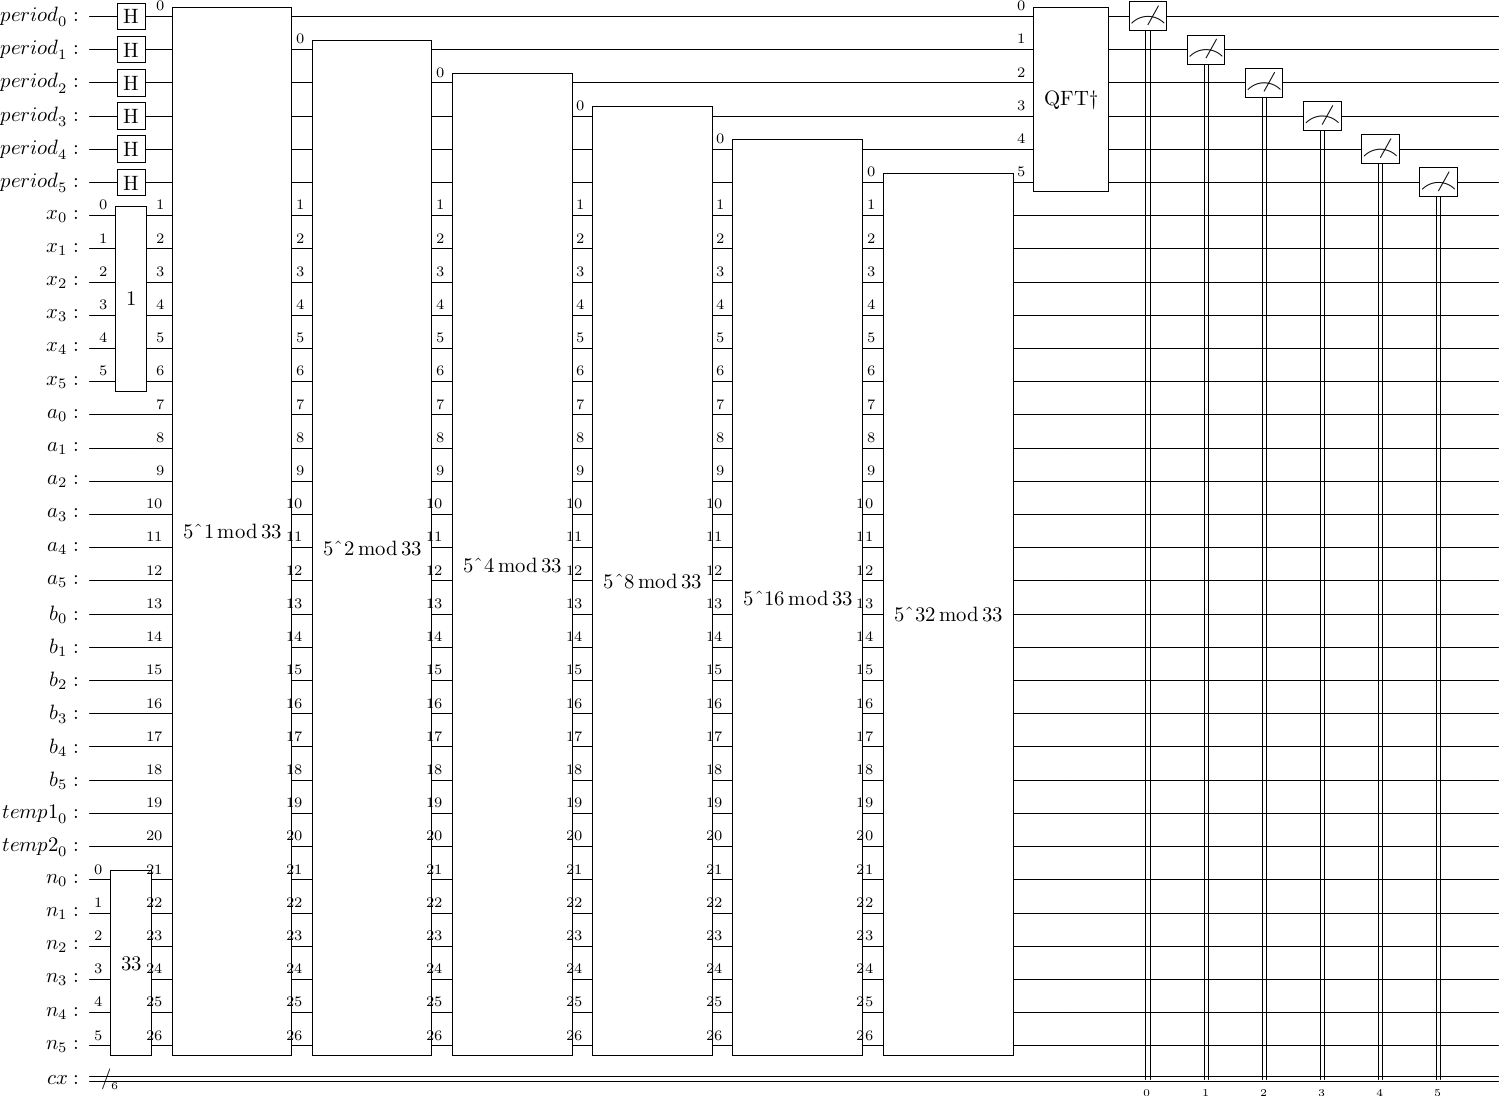

In [22]:
N = 33
#numx = 6
numa = 5
nbits = 6
mbits = nbits

period = QuantumRegister(mbits,"period")
out1 = QuantumRegister(nbits,"x")  #output 1
tempa = QuantumRegister(nbits,"a")#temp from adder (nbits)
out2 = QuantumRegister(nbits,"b")  #temp from cmult
t1 = QuantumRegister(1,"temp1")       #temp from adder (1)
t2 = QuantumRegister(1,"temp2")       #temp from adder (1)
n = QuantumRegister(nbits,"n")        #N               (nbits)
cx = ClassicalRegister(mbits,"cx")    #answer (same size as xreg)


qc = QuantumCircuit(period, out1, tempa, out2, t1, t2, n, cx)
#qc.append(x(14,mbits),period[:])
qc.h(period[:])
qc.append(x(1,nbits),out1[:])
qc.append(x(N,nbits),n[:])
for p in range(mbits):
    qc.append(makea2pmod(out1, tempa, out2, t1, t2, n, numa,p,nbits,N),[p] + list(range(mbits,mbits+4*nbits+2)))

#tried to use qarethmetic, didnt work    
# QFTcirc = QuantumCircuit(nbits)
# QFTcirc.name = "QFT"
# qft(QFTcirc,range(nbits),nbits)
qc.append(QFTd(nbits),range(nbits))
qc.measure(period,cx)
qc.draw(fold=-1,output = "latex")


In [ ]:
qasmsim = provider.get_backend('ibmq_qasm_simulator')
tqc = transpile(qc,qasmsim)
results = qasmsim.run(tqc,shots=10000).result()
plot_histogram(results.get_counts())

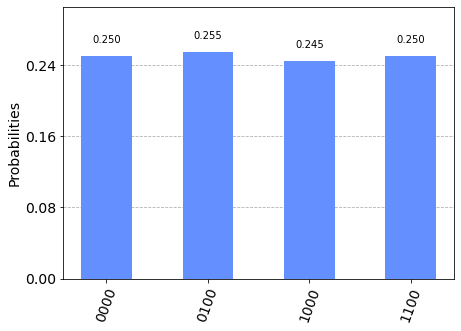

In [13]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=10000).result()
plot_histogram(results.get_counts())


In [ ]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=50).result()
plot_histogram(results.get_counts())

In [ ]:
checkedlist = []
factorfound = 0
#print(2**nbits)
for output in results.get_counts():
    if results.get_counts()[output] > 30: # trying to remove any measurements from random noise
        phase = int(output,base=2)/(2**nbits)
        #print(int(output,base=2))
        r = Fraction(phase).limit_denominator(int(N/2)).denominator #r should be below 63/2, i hope
        if r not in checkedlist:
            checkedlist.append(r)
            #print(r)
            if r > 1 and r % 2 == 0:
                if int(2**(r/2)) <= 2**62: #gcd requires numbers below 2^64
                    p1 = np.gcd(int(2**(r/2)-1),N)
                    p2 = np.gcd(int(2**(r/2)+1),N)
                    plist = [p1,p2] if p1 <= p2 else [p2,p1]
                    if p1 * p2 == N and p1 != 1 and p2 != 1:
                            print(" "*abs(2 - len(str(plist[0])))+str(plist[0])+\
                            " *"+" "*abs(3 - len(str(plist[1])))+str(plist[1])+" ="+\
                            " "*abs(3 - len(str(N)))+str(N)+\
                            ", r ="+" "*abs(3 - len(str(r)))+str(r)+\
                            ", nbits ="+" "*abs(2 - len(str(nbits)))+str(nbits)+\
                            ", checked periods before this were "+str(checkedlist[:-1]))
                            factorfound = 1
if not factorfound:
    print(N,"is prime or cannot be found with x = 2")

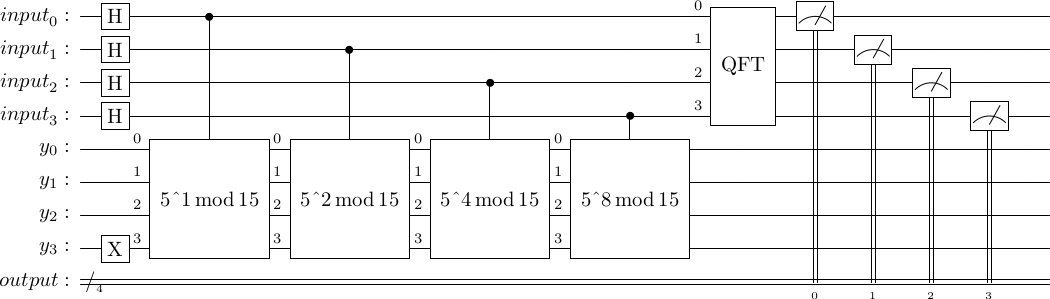

In [8]:
#some code left over from last month
#oh hey the cicuits for x = 2 and N = 2^n - 1 happen to be extremely easy
power2 = 6
global power2
N = 2**power2 - 1

def powermodp2(power): #multiply by 2^p (mod 2^n-1)
    global power2
    U = QuantumCircuit(power2)
    for i in range(power):
        for j in range(power2-1):
            U.swap(j,j+1)
    U = U.to_gate()
    U.name = "5^"+str(power)+" mod "+str(33)
    c_U = U.control()
    return c_U

# def QFTd(n): #source qiskit
#     circuit = QuantumCircuit(n)
#     for bit in range(n//2):
#         circuit.swap(bit,n-bit-1)
#     for j in range(n):
#         for m in range(j):
#             circuit.cp(-np.pi/(2**(j-m)), m, j) 
#             #rotate by -pi/2^(j-m) on the bit j (target), which is controlled by each less significant bit m
#         circuit.h(j)
#     circuit.name = "Inverse QFT"
#     return circuit

nbits = power2
xreg = QuantumRegister(nbits,"input")
y = QuantumRegister(power2,"y")
cx = ClassicalRegister(nbits)
qc = QuantumCircuit(xreg,y,cx) #31 is expressed by 5 bits, so the output register of the mod function is length 5
qc.h(xreg[:])
qc.x(nbits + power2 - 1)
for k in range(nbits):
    qc.append(powermodp2(2**k),[k] + y[:])

# QFTcirc = QuantumCircuit(nbits)
# QFTcirc.name = "QFT"
# qft(QFTcirc,range(nbits),nbits)
# qc.append(QFTcirc,range(nbits))
qc.append(QFTd(nbits),range(nbits))
#qc.barrier()
qc.measure(range(nbits),range(nbits))
#qc = qc.decompose()

qc.draw(fold=-1,output="latex")


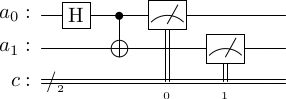

In [14]:
a = QuantumRegister(2,"a")
c = ClassicalRegister(2,"c")
circ = QuantumCircuit(a,c)

circ.h(0)
circ.cx(0,1)
circ.measure([0,1],[0,1])


circ.draw(output="latex")


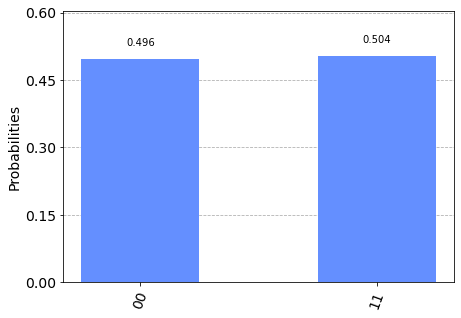

In [25]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(circ,aersim)
results = aersim.run(tqc,shots=10000).result()
plot_histogram(results.get_counts())
# d = results.get_counts()
# oldkeys = list(d.keys())
# # for key in oldkeys: #the jank required to plot this graph how i want defies the bounds of reality
# #     d[str(int(key,2))] = d[key]
# #     del d[key]
# x = np.arange(0,2**2,1)
# y = np.zeros(len(x))
# for i,xi in enumerate(x):
#     if str(xi) in d.keys():
#         y[i] = d[str(xi)]
# plt.xlim(-0.5,2**2-.5)
# plt.bar(x,y,color=(0.4,0.6,1))
# y